<a href="https://colab.research.google.com/github/ghr8635/ROS2-Modular-Framework-for-End-to-End-Autonomous-Vehicle-Control-from-Raw-Sensor-Data/blob/main/Training_Transformer_with_Toy_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install torch transformers pandas numpy matplotlib


In [4]:
import pandas as pd

# Load dataset
url = 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv'
data = pd.read_csv(url)
data.head()


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


In [5]:
data['date'] = pd.to_datetime(data['date'])  # Convert to datetime if needed
data.set_index('date', inplace=True)         # Set the date as index


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


In [7]:
import numpy as np

def create_sequences(data, seq_length=48):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 48  # Adjust based on dataset and needs
X, y = create_sequences(scaled_data, seq_length)


In [8]:
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


In [9]:
import torch
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = self.fc_out(x[:, -1, :])  # Take the last timestep
        return x

# Define model parameters
input_dim = X_train.shape[2]
d_model = 64
nhead = 4
num_layers = 2
output_dim = y_train.shape[1]

model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, output_dim)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [11]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [14]:
epochs = 10  # Adjust based on performance

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}")


Epoch 1, Train Loss: 0.0045010485540391285, Val Loss: 0.0016837543861992837
Epoch 2, Train Loss: 0.0012484386563033619, Val Loss: 0.0014482389750968933
Epoch 3, Train Loss: 0.0010350999832232223, Val Loss: 0.001400937632810583
Epoch 4, Train Loss: 0.0009419524802358009, Val Loss: 0.0015467686838696823
Epoch 5, Train Loss: 0.0009030789196866232, Val Loss: 0.0013650614257647983
Epoch 6, Train Loss: 0.0008908920539708863, Val Loss: 0.001333147228159835
Epoch 7, Train Loss: 0.000878044516492757, Val Loss: 0.0013166917697246157
Epoch 8, Train Loss: 0.0008740475338627999, Val Loss: 0.0013082688783636956
Epoch 9, Train Loss: 0.0008609798704239228, Val Loss: 0.0013053924840361782
Epoch 10, Train Loss: 0.0008607718503193065, Val Loss: 0.0013469861111902192


In [15]:
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        output = model(X_batch)
        predictions.append(output)
        actuals.append(y_batch)

predictions = torch.cat(predictions).numpy()
actuals = torch.cat(actuals).numpy()

# If scaled, inverse the scaling
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(actuals)


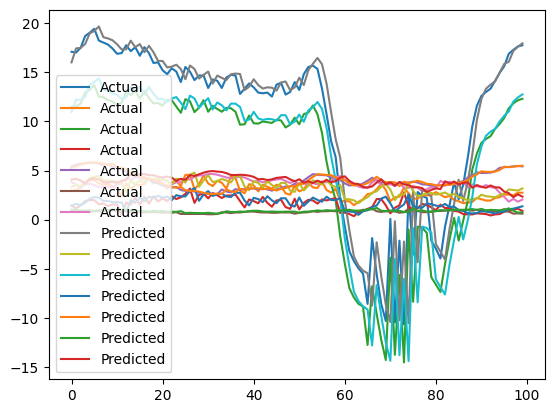

In [16]:
import matplotlib.pyplot as plt

plt.plot(actuals[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.legend()
plt.show()
